In [1]:
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt

from ABCA7lof2.setup import get_data, save_all, save_annotations, subset_mat
from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts
from ABCA7lof2.annotation import get_major_annotations


config.THREADING_LAYER = 'workqueue'

In [2]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'

# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


Quality control for cell inclusion
Outlier cells with less than 500 or more than 10,000 genes detected were excluded, and only genes detected in at least 10 cells were considered. The following quality measures were quantified for each cell: (1) the number of genes for which at least one read was mapped (indicative of library complexity); (2) the total number of counts; and (3) the percentage of reads mapped to mitochondrial genes (used to approximate the relative amount of endogenous RNA and commonly used as a measure of cell quality). Cells with a discriminatively high ratio of mitochondrial to non-mitochondrial read counts were excluded using unbiased k-means clustering-based binarization (k = 2). Nuclear-encoded protein-coding genes were considered for downstream analyses.



Labels = [0 1]
counts per label = [124521  25914]


  0%|          | 0/124521 [00:00<?, ?it/s]

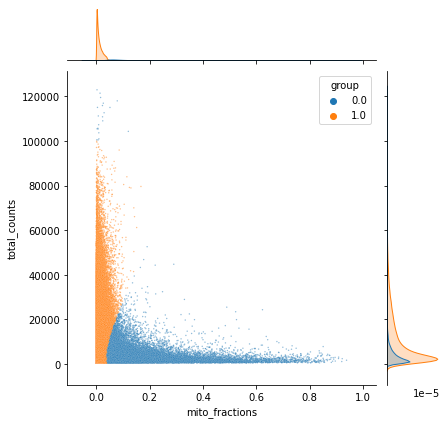

In [12]:
# filter by cells prior to annotation
pdf = plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf')
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, .25, 500, 100000, pdf, 'MT-', './processed_data/single_cell')

In [ ]:
# run the below functions, then check the output to the previous QC'ed data
# then check the aggregation (against previously QC'ed)
# then run the tests on the QC/anno functions to make sure all ok

In [ ]:
# annotate the major cell types
echo(f"annotating major cell types", underline=True)
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations(args.marker_path, gene_names, filtered_counts, total_counts, args.sample_size, args.n_components_pca, args.n_components_gaussian, path_to_outputs, args.infer_N_markers)

In [ ]:
# filter by Gaussian logliklihood
echo(f"filtering by logliklihood", underline=True)
keep_cells_1 = filter_on_gaussian_logliklihood(scores)

In [ ]:
# annotate the major cell types
echo(f"annotating major cell types", underline=True)
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations(args.marker_path, gene_names, filtered_counts, total_counts, args.sample_size, args.n_components_pca, args.n_components_gaussian, path_to_outputs, args.infer_N_markers)

In [ ]:
# compile everything into the final metadata
filtered_meta_final = np.concatenate((filtered_meta,(keep_cells_1&keep_cells_2).reshape(-1,1), keep_cells_mito.reshape(-1,1), keep_cells_individual.reshape(-1,1), predict.reshape(-1,1), scores.reshape(-1,1), annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((meta_col_names, np.array(('keep_cells_all_per_celltype', 'keep_cells_mito_per_celltype', 'keep_cells_individual', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)

In [ ]:
    # filter by major cell type annotation
    echo(f"intra-celltype filtering", underline=True)
    individual_annotation = filtered_meta[:,1]
    keep_cells_2, keep_cells_mito, keep_cells_individual, keep_genes, keep_individuals = filter_cells_by_major_annotation(mito_fractions, total_counts, args.sample_size, predict, individual_annotation, filtered_counts)

    

In [4]:
test = pd.read_csv('../apoe4myelin/uploading_fastq_files/qc_column_metadata.csv')